In [4]:
import moneymaker as mm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import yfinance as yf
from sklearn.pipeline import make_pipeline

plt.rcParams["figure.figsize"] = (15,3.5)
plt.rcParams["axes.grid"] = True

## Get some dayly data
#### CARNIVAL CRUISELINE

Open         High          Low        Close        Volume  \
count  5032.000000  5032.000000  5032.000000  5032.000000  5.032000e+03   
mean     32.441612    32.790089    32.068832    32.432997  7.101798e+06   
std      12.158065    12.185691    12.129831    12.151918  1.365623e+07   
min       8.010000     8.530000     7.800000     7.970000  2.636000e+05   
25%      24.427509    24.705079    24.076514    24.417613  2.599950e+06   
50%      30.379851    30.666712    30.057931    30.343619  3.625250e+06   
75%      38.629967    38.927118    38.138818    38.534087  5.332350e+06   
max      66.208364    66.917109    65.932222    66.217583  2.620611e+08   

         Dividends  Stock Splits  
count  5032.000000        5032.0  
mean      0.003913           0.0  
std       0.036068           0.0  
min       0.000000           0.0  
25%       0.000000           0.0  
50%       0.000000           0.0  
75%       0.000000           0.0  
max       0.500000           0.0

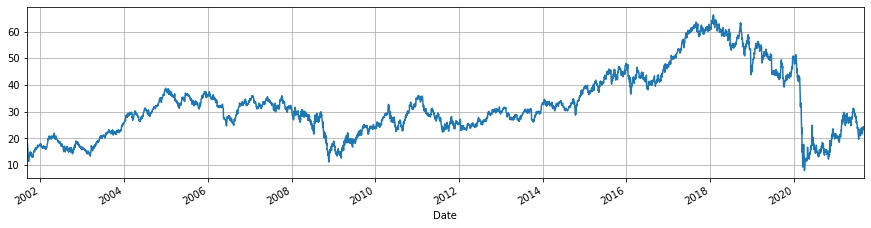

In [5]:
# get historical market data
ccl = yf.Ticker("CCL")
ohlcv = ccl.history(period='20y')
ohlcv.Close.plot()
ohlcv.describe()

## Test some indicators

### ATR

In [6]:
# just look at last 400 trading days

ohlcv400 = ohlcv[-400:].copy()

def make_fit_transform(*args):
    p = make_pipeline(*args)
    return p.fit_transform(ohlcv400)

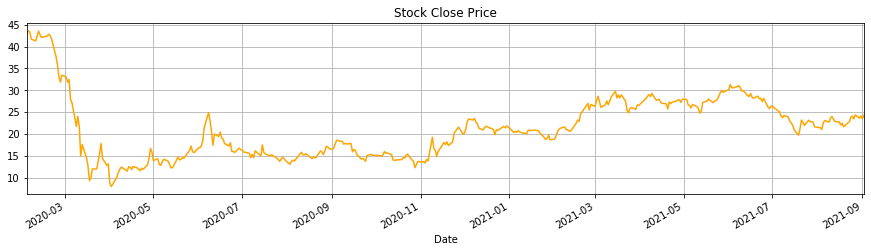

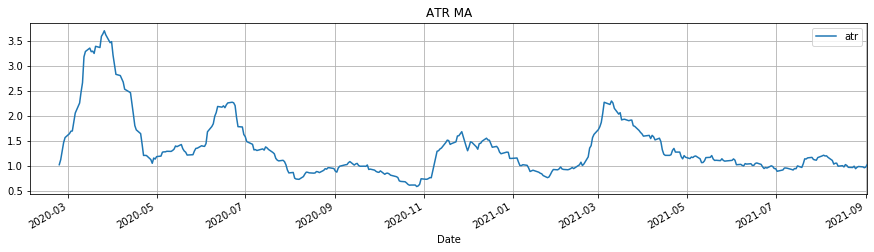

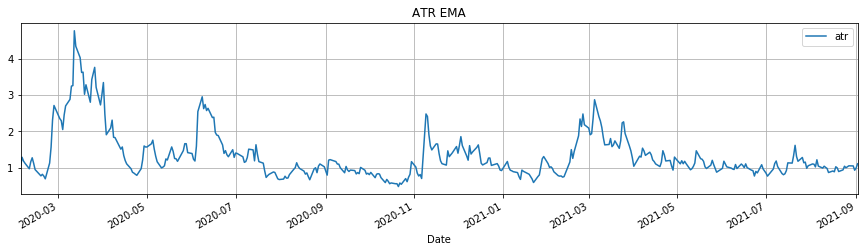

In [19]:
#calc

atr = make_fit_transform(mm.ATR())
atr_ema = make_fit_transform(mm.ATR(matype="ema", ))
#plot
ohlcv400.Close.plot(color="orange", title="Stock Close Price")
#plt.show()
atr.plot(title="ATR MA")
atr_ema.plot(title="ATR EMA")

#### ATR as bands

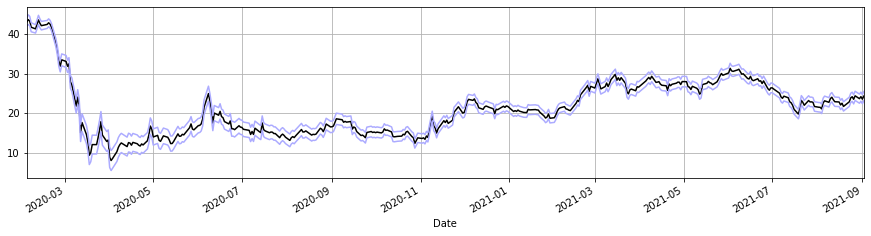

In [10]:
ohlcv400.Close.plot(color="black")
(atr_ema.atr + ohlcv400.Close).plot(color="#ACABFF")
(-atr_ema.atr + ohlcv400.Close).plot(color="#ACABFF")

#### ATR vs std dev

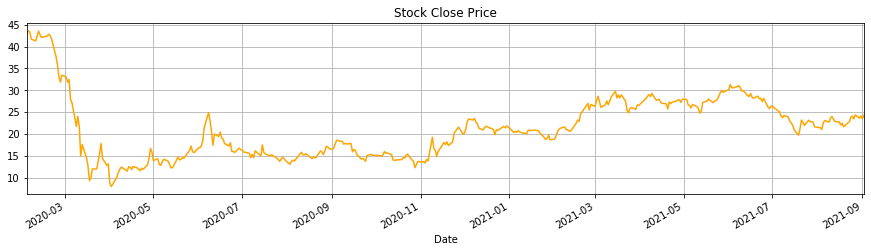

In [18]:
# Std dev is no implemented indicator..
# Perfect test for our wrapper class!

def rollingstd(X):
    return X.rolling(14).std().pow(0.5).set_axis(["std dev"],axis=1,inplace=False)

std = make_fit_transform(
      # get only close
      mm.FromOHLCV('c',df=True)
      # use of wrapper class for custom func in pipe
    , mm.Wrapper(rollingstd)
)
ohlcv400.Close.plot(color="orange", title="Stock Close Price")

pd.concat([atr,std],axis=1).plot()

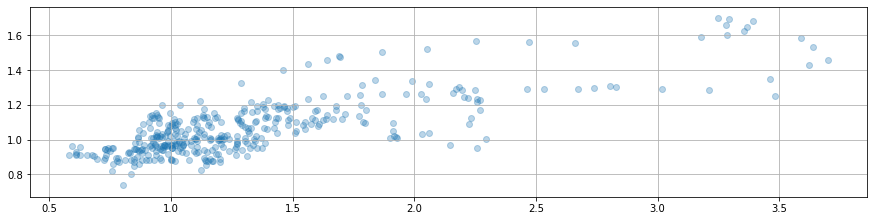

In [13]:
plt.scatter(atr,std**.5,alpha=.3)

### Bollinger Bands

In [22]:
bb = make_fit_transform(mm.FromOHLCV('c',df=True), mm.BollingerBands(bands="both",stddevs=3))

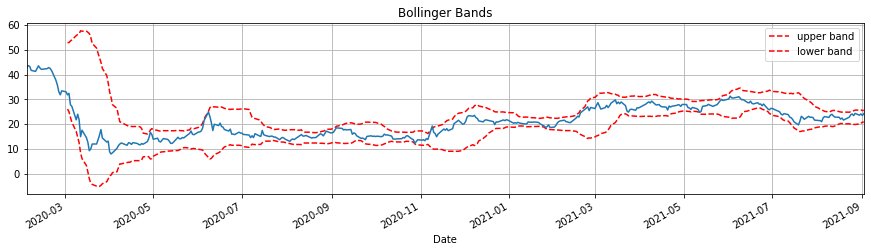

In [23]:
bb.plot(color="red",linestyle="--",title="Bollinger Bands")
ohlcv400.Close.plot()

### Multi MA

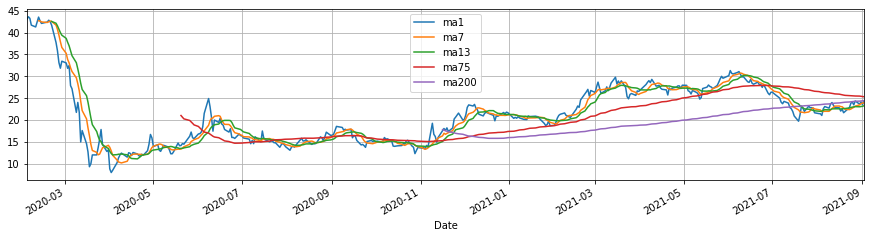

In [24]:
ma = make_fit_transform(mm.FromOHLCV('c',df=True), mm.MA(window=[1,7,13,75,200]))
ma.plot()

Also check EMA, VWMA, VWEMA ...

But for now, let's switch to intraday data!

## Get some intraday data
#### BTCUSDT

Open           High            Low          Close  \
count  130563.000000  130563.000000  130563.000000  130563.000000   
mean    38411.213568   38437.744819   38385.060259   38411.298619   
std      5736.373866    5736.722363    5735.607507    5736.456248   
min     28867.270000   28987.420000   28805.000000   28867.830000   
25%     33673.530000   33693.640000   33654.055000   33673.400000   
50%     36744.510000   36780.000000   36707.750000   36744.580000   
75%     43619.995000   43650.055000   43589.750000   43620.650000   
max     50454.590000   50500.000000   50442.090000   50454.590000   

              Volume  
count  130563.000000  
mean       47.933304  
std        69.433694  
min         0.918309  
25%        17.890919  
50%        29.442826  
75%        52.279841  
max      2636.713888

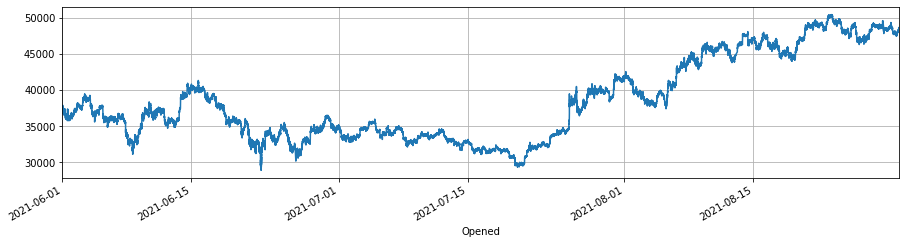

In [25]:
mypath = '1m_data/BTCUSDT/individual_csvs'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
coin = pd.concat([pd.read_csv(mypath + '/' + o,index_col=0) for o in files])
coin.index = pd.to_datetime(coin.index)
coin.Close.plot()
coin.describe()

Redefine make_fit_tranform:

In [26]:
# just look at last 20 trading days

coin20 = coin[-20*60*24:].copy()

def make_fit_transform(*args):
    p = make_pipeline(*args)
    return p.fit_transform(coin20)

### Run some indicators

### VWAP

In [27]:
vwap = make_fit_transform(
    mm.FromOHLCV('cv',df=True)
    , mm.VWAP()
)
pd.concat([coin20.Close, vwap],axis=1).plot(title="VWAP")
#plt.gca().set_yscale('log')
plt.show()
coin20.Volume.plot(title="Volume")



In [29]:
create_cv = make_pipeline(
    mm.RandomOHLCV(seed=44, start_price=14.50, freq="1min",),
)

vwap = make_pipeline(mm.FromOHLCV('cv',df=True),mm.VWAP())
ma = make_pipeline(mm.FromOHLCV('c',df=True),mm.MA(60))

res = create_cv.fit_transform(31)
res_vwap = vwap.fit_transform(res)
res_ma = ma.fit_transform(res)

In [40]:
res.close

timeidx
2021-01-01 09:30:00    14.516508
2021-01-01 09:31:00    14.519513
2021-01-01 09:32:00    14.519302
2021-01-01 09:33:00    14.513632
2021-01-01 09:34:00    14.511187
                         ...    
2021-01-29 15:55:00    13.928813
2021-01-29 15:56:00    13.929360
2021-01-29 15:57:00    13.928656
2021-01-29 15:58:00    13.928179
2021-01-29 15:59:00    13.926965
Name: close, Length: 8190, dtype: float64

In [43]:
pd.concat([pd.DataFrame(res.close),res_vwap,res_ma],axis=1)

close       vwap         ma
timeidx                                             
2021-01-01 09:30:00  14.516508  14.516508        NaN
2021-01-01 09:31:00  14.519513  14.517455        NaN
2021-01-01 09:32:00  14.519302  14.517510        NaN
2021-01-01 09:33:00  14.513632  14.517429        NaN
2021-01-01 09:34:00  14.511187  14.516761        NaN
...                        ...        ...        ...
2021-01-29 15:55:00  13.928813  13.931055  13.931352
2021-01-29 15:56:00  13.929360  13.931049  13.931325
2021-01-29 15:57:00  13.928656  13.931040  13.931321
2021-01-29 15:58:00  13.928179  13.931035  13.931354
2021-01-29 15:59:00  13.926965  13.930983  13.931306

[8190 rows x 3 columns]

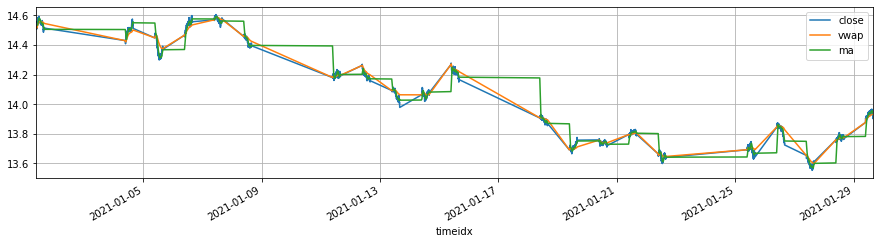

In [44]:
pd.concat([pd.DataFrame(res.close),res_vwap,res_ma],axis=1).plot()
#res_vwap.plot()
#res_ma.plot()